<a href="https://colab.research.google.com/github/jasmineA20/Avocodo/blob/main/Monte_Carlo_Simulations_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Last Time: Ising Models

Last time we introduced the Ising model which is a model for how spins in ferromagnetic systems align with one another.  In 1D our model looks like this:

$\uparrow \uparrow \downarrow \downarrow$

For four spins.  We can compute the energy of this configuration by adding up the pairwise interaction of neighboring spins:

$E = \sum_{neighbors} -J \sigma_i \sigma_j$ 

where spins that are pointing up are denoted by $sigma = 1$ and spins that are pointing down by $\sigma = -1$. 

#Monte Carlo Simulations

The above algorithm for calculating the properties of an Ising model will work, but it quickly becomes impossible to solve.  For example, if you had a system of 100 spins, then there would exist $2^{100}=10^{30}$ configurations.  Even if your computer can do a billion operations per second, it would still take on the order of $10^{13}$  years to iterate through all of the configurations.  This is a thousand times longer than the age of the universe!!!  Clearly, this is not the way.

The solution is not to sample all of the configurations, but to sample them at random.   Naively, if you wanted to calculate the average net magnetization by: 

$\left<M\right> = \frac{\sum_i M_i e^{-\frac{E_i}{k_BT}}}{\sum_i e^{-\frac{E_i}{k_BT}}} $

you might try to generate a large number of random spin arrays and then to use them in the above formula (similar to what we did with Monte Carlo integration).  The code below does exactly this, and it prints out the average magnetization, along with creating plots of the energy of each random configuration and the probability of that configuration based on the Boltzmann factor.

Running it multiple times there are a few things to note:

1.  It's difficult to find low energy (E<-35 for example) configurations.  (Note the minimum energy for $N=50$ and $J=1.0$ is -49.  Note that even a state with $E=-35$ is still highly unlikely to naturally occur at $kT=0.5$ from the Boltzmann factor, relative to a state with $E=-49$

  $p = e^{-\frac{-(-35+49)}{0.5}}= 3.14 \cdot10^{-17}$

2.  Even for the configurations that are sampled, only a few of them will contribute to the final weighted average for $M$.

3.  We should be getting fairly high values of $M$.  For $N=10$ we get that our system is highly magnetized, but for $N=100$ it is much lower.  

The average net magnetization of the system is <M> = 0.0200


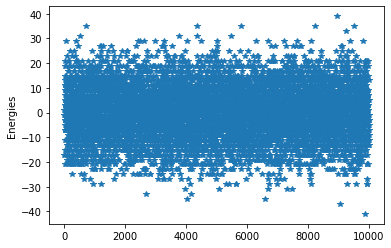

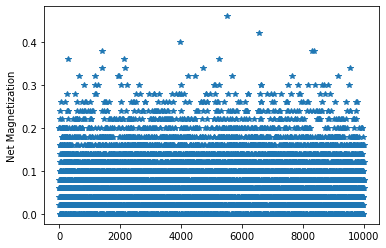

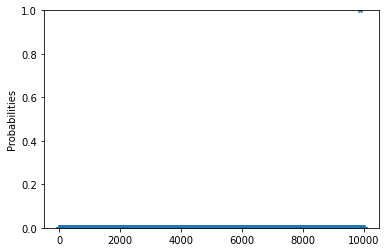

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Input values for the simulation
N = 100
iters = 10000
J = 1.0
kT = 0.5

#function for calculating the energy of a spin array
def energy_function(spins):
  energy = 0.0
  for i in range(len(spins)-1):
    energy += -1.0 * J * spins[i]*spins[i+1]
  return energy

#setup the arrays for storing the energies and M, and variables for the average M and Z
energies = np.zeros(iters)
M = np.zeros(iters)
M_aver = 0.0 
Z = 0.0

for i in range(iters): #perform iterations
  spins = 2*np.random.randint(2,size=N)-1 #setup an array of random spines
  E = energy_function(spins) #energy for that configuration
  M[i] = np.abs(np.sum(spins))/N #M for that configuration
  M_aver += M[i] * np.exp(-1.0 * E / kT) #weighted M for that configuration
  energies[i]=E #store the energy for that configuration
  Z += np.exp(-1.0 * E/kT) #add to Z for that configuration

#Plot the results
print("The average net magnetization of the system is <M> = %6.4f"%(M_aver/Z))
plt.plot(energies,'*')
plt.ylabel("Energies")
plt.show()

plt.plot(M,'*')
plt.ylabel("Net Magnetization")
plt.show()

probs = np.exp(-1.0*(energies-np.min(energies))/kT) #calculate unnormalized probabilities
probs /= np.sum(probs) #normalize probabilities
plt.plot(probs,'*')
plt.ylabel("Probabilities")
plt.ylim(0,1)
plt.show()

The naive random sampling doesn't work that well.  Why? Because even though we're sampling at random, many of the configurations we sample have a high energy, and thus a low probability of being observed because of the Boltzmann distribution.  So there's little need to include them in our calculations.  To make matters worse, we miss many of the low energy, high probability configurations (which will become clear below).  The solution is to come up with a way to preferentially sample high probability/low energy configurations.   This idea is part of the broader field of *importance sampling*, in which we preferentially sample the important parts of our distribution. 

Here, the algorithm of Markov Chain Monte Carlo simulations is described.  To preferentially sample low energy/high probability configurations we:

1.  Choose a random starting configuration.  Here, that is a random string of spins.

2.  Calculate the energy of the system.  We'll call that $E_i$.

3.  Try randomly changing our system.  Here, that corresponds to picking a spin at random and flipping it (that is, we multiply a random spin by -1).

4.  Calculate the new energy of the system after this change. We'll call that $E_j$.

5.  Use the difference in energies between $E_i$ and $E_j $ to determine if we'll keep the random change we made.  To do that there are two cases:

  A.  If $E_j<E_i$ then the random move we made reduced the system's energy and we keep the random move.

  B.  If $E_j >E_i$  then the random move we made increases the energy of the system.  We will keep the random move we made with the probability of:

   $ p = e^{-\frac{E_j-E_i}{k_BT}}$

   (which is the ratio of the Boltzmann factors of the two configurations).  Since this ratio is by definition between 0 and 1, we can code this acceptance criteria with the following if statement:

   ```if np.random.random() < np.exp(-(Ej-Ei)/kT):  accept change```

    This is the "Metropolis Criteria."  Its goal is to keep each of the sampled configurations in the correct probability as determined by statistical mechanics. 

6.  Repeat steps 2-5 for however many iterations it takes to converge your results (or as long as you can afford).

One nice aspect of this method is that because you are sampling configurations with the correct (Boltzmann) probability, any observable you want to calculate is simply the average of what you observe over the calculation (you don't need to multiply it by a Boltzmann factor). Note that you may need to discard an initial portion of your simulation as it comes to equilibrium when you do this (people often refer to this as letting the simulation "burn in"). 

**Activity:** To see how this work, the code below implements a Markov Chain Monte Carlo simulation of the 1D Ising model we've been dealing with.  First, examine how it functions.  Can you see how the above algorithm is implemented in this code?  Then, run it with the same set of parameters you ran with the naive approach. Answer the following:

1.  For the same set of parameters, how do the energies and spins of the sampled states compare?

2.  Compare the relative probabilities sampled in this method and the naive approach.  Which method has more even sampling?  That is, in which method do you see more configurations sampled that have relatively high probabilities?

3.  Try running the code with various values of $N$, $kT$, and $iters$.  How does the number of iterations you need to compute a reliable answer depend on these parameters? 

The average net magnetization of the system is <M> = 0.2179


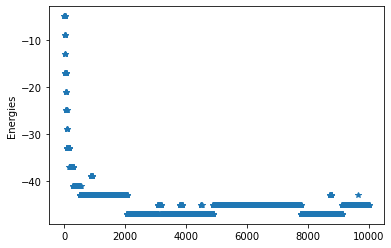

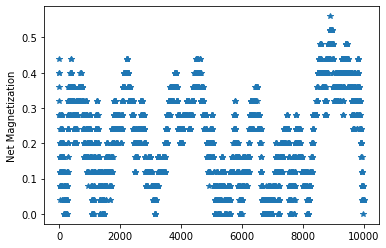

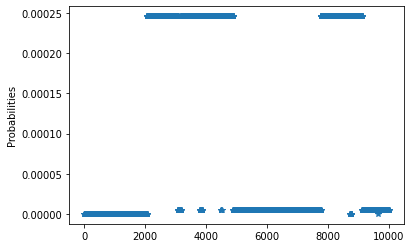

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Input values for the simulation
N = 50
iters = 10000
J = 1.0
kT = 0.5


#function for calculating the energy of a spin array
def energy_function(spins):
  energy = 0.0
  for i in range(len(spins)-1):
    energy += -1.0 * J * spins[i]*spins[i+1]
  return energy

#setup the arrays for storing the energies and magnetization, and an initial random spin array
energies = np.zeros(iters)
M = np.zeros(iters)
spins = 2*np.random.randint(2,size=N)-1

for i in range(iters): #Perform iterations
  E_orig = energy_function(spins) #energy for that configuration
  flipper = np.random.randint(N) #pick a random spin to flip
  spins[flipper] *= -1 #flip that spin
  E_flipped = energy_function(spins) #find the energy of the system with the new spin state
  if E_flipped < E_orig or np.random.random() < np.exp(-1.0*(E_flipped-E_orig)/kT): #Check the metropolis criteria
    #Accept the move if criteria are met
    E = E_flipped
  else:
    #Undo the move if criteria are not met
    E = E_orig
    spins[flipper] *= -1

  M[i] = np.abs(np.sum(spins))/N #M for that configuration
  energies[i]=E #E for that configuration

#Plot the results
M_aver = np.mean(M)
print("The average net magnetization of the system is <M> = %6.4f"%M_aver)
plt.plot(energies,'*')
plt.ylabel("Energies")
plt.show()

plt.plot(M,'*')
plt.ylabel("Net Magnetization")
plt.show()

probs = np.exp(-1.0*(energies-np.min(energies))/kT) #calculate unnormalized probabilities
probs /= np.sum(probs) #normalize probabilities
plt.plot(probs,'*')
plt.ylabel("Probabilities")
plt.show()

The 1D Ising model is a somewhat boring system, and one that can be solved analytically.  A system that can NOT be solved analytically is the Ising model in two (or higher) dimensions.  You can visualize this model as spins that look like this:


$\uparrow \uparrow \downarrow$

$\downarrow \uparrow \downarrow$

$\downarrow \uparrow \downarrow$

For a 3x3 grid.  The only difference between the 1D and 2D case is how we calculate the energy.  

Below is code to run a Monte Carlo simulation of the 2D Ising model.  These calculations are scientifically more expensive than the previous calculations you've done, so it may take some time to run.  There are several parameters that you can tune which may help you out.  These include:

* size: the system's size
* T: The temperature.  Note that temperature is scaled relative to J above, so we've implicitly set J = 1.0
* numtrials: The number of Monte Carlo trials to make
* animateskip: The code will make a move at the end.  You (typically) don't want ever frame to come up in your movie, so this will dictate how many trials to skip between frames.  This can have a significant impact on the speed of making the movie.
* dataskip: Like above, you may not want to save your data every step if you take a lot of steps.  This will dictate how many trials to skip between times when the data is saved.

Note that we can save a large amount of time by not actually calculating the energy at each trial, but instead just the CHANGE in energy.  To do this, we pick a random spin we are going to try to flip.  The change in energy associated with that flip is completely dictated by its four neighbors.  It turns out we can calculate $\Delta E$, the change in energy of flipping spin $(i,j)$ as:

$\Delta E = 2 * \sum_{neighbors}{\sigma_i}$

This is done in the ```deltaE``` routine below.

**Activity:**

1.  Start with a small system of size=10. Run for 100 steps and save the animation and magnetization every step.  View the move a few times and note how the simulation performs.  Do you see much of a change in 100 steps?  How about 1000 steps?

2.  Increase the system size to $N=25$.  Set the other following paramaters:

```
size = 25 #lattice length
T =1.0 # in units of J/k
numtrials = 200000
animateskip=1000
dataskip=10
```

Run the simulation and note the behavior of the net magnetization.  Does it converge to a defined value?  What is the movie of your simulation look like?

3.  Try changing the temperature in increments of 0.5 (so try values like 0.5, 1.5, 2.0, 2.5, and 3.0).  How does the behavior of the system change?  Can you guess why you see this behavior?

4.  If you have time, pick a temperature that you thought was interesting.  Try making your system bigger.  How does your simulation change?

Import the necessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.cm as cm
import time
import math
from IPython.display import HTML

Here are the main variables you can change.  Size affects how large your system is, T is a dimensionless temperature, and skip affects how often the results are plotted.  You can modify the length of your simulation by changing numtrials.  Note that larger simulations will require more trials to reach the same level of convergence.

In [ ]:
size = 100 #lattice length
T =2.0 # in units of J/k
numtrials = 100
animateskip=1
dataskip=1

This function sets up your initial spin array with random values of 0 or 1 in each spot

In [ ]:
def initialize():
    spinarray = np.random.random([size,size]) # initializes with random numbers from 0 to 1.
    spinarray[spinarray<0.5] = -1 #If an array element has a value of less than 0.5, set it to -1
    spinarray[spinarray>0.5] = 1 #If an array element has a value of greater than 0.5, set it to 1
    return spinarray

Function for computing the change in energy if spin i,j is flipped.  Note that we are using "periodic boundary conditions," which means that if we are looking at a spin on the edge of the box then we say its neighbor is on the other size (that is, the box wraps around so that there are no edges).

In [ ]:
def deltaE(i,j):
    leftS = s[i-1,j] 
    if i==size-1:
      rightS = s[0,j] 
    else:
       rightS= s[i+1,j]
    bottomS = s[i,j-1]
    if j==size-1:
      topS = s[i,0]
    else:
      topS = s[i,j+1]
    return 2.0 * s[i,j] * (leftS + rightS + topS + bottomS)

This is a routine for plotting your spins as the simulation proceeds. Note you can change the colormap to any of the user defined types: http://matplotlib.org/examples/color/colormaps_reference.html

In [ ]:
def colorsquare(frame):
    pt1.set_data(anim_frames[frame,:,:])
    frame_num = frame*animateskip
    txt_title.set_text(('Frame = %8i'%frame_num))
    return pt1,

This is the main portion of our code.

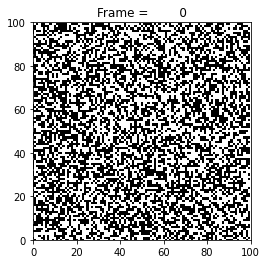

Time to completion:  0.06936502456665039 s


In [ ]:
s = initialize()   #Inititialize the spin matrix with random values
av_mag=np.zeros(int(numtrials/dataskip+1))      #Set up the arrays for storing average magnetization and correlation
av_mag[0]=np.abs(np.mean(s))
#The following are all commands needed to make a movie of your simulation

anim_frames=np.zeros((int(numtrials/animateskip),size,size))
num_animation = 0

# Setup our figure and axes for animation
fig = plt.figure()
ax1 = plt.subplot()

# set up the plot as needed
ax1.set_xlim(( 0,size))            
ax1.set_ylim((0,size))

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('Frame = %8i'%0)
pt1 = ax1.imshow(s, interpolation='nearest',cmap=cm.Greys_r,animated=True)
plt.show()

start=time.time() #get the system's time to let us know how long we run for
for trial in range(1,numtrials+1): #main loop
    i = int(np.random.random()*size)# choose random row 
    j = int(np.random.random()*size)# choose random column
    ediff = deltaE(i,j) #perform an energy evaluation for flipping that element
    if ediff <= 0: # flipping reduces the energy
      s[i,j] *= -1
    elif np.random.random() < math.exp(-ediff/T): #flipping increases the energy, so do it with a Metropolis criteria
      s[i,j] *= -1
    if trial%dataskip==0:   #save data at the specified frequency
      av_mag[int(trial/dataskip)]=np.abs(np.mean(s))
    if trial%animateskip==0: #save date to be plotted at a specified frequency
      anim_frames[num_animation,:,:] = s
      num_animation += 1

anim = animation.FuncAnimation(fig, colorsquare, interval=20, blit=True,frames=num_animation)
stop=time.time() #get the system's time 
print("Time to completion: ",stop-start,"s")

Plot the net magnetization and also compute the average of this quantity over the first and last half of the simulation.

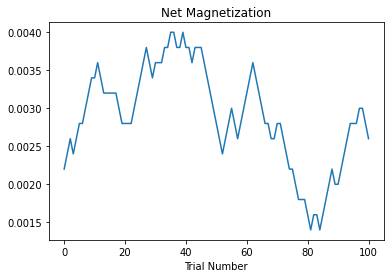

Average magnetization over first half of the simulation = 0.003305882352941177
Average magnetization over last half of the simulation = 0.0024760000000000003


In [ ]:
plt.plot(np.linspace(0,numtrials,len(av_mag)),av_mag)
plt.title('Net Magnetization')
plt.xlabel('Trial Number')
plt.show()
av_mag_1, av_mag_2 = np.array_split(av_mag,2)
print('Average magnetization over first half of the simulation =',np.mean(av_mag_1))
print('Average magnetization over last half of the simulation =',np.mean(av_mag_2))

Make the movie of the simulation.  Note that this can be quite slow if you savesd a lot of frames.

In [ ]:
HTML(anim.to_html5_video())